# Measuring Word Similarity with BERT (English Language Public Domain Poems)

By [The BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team

How can we measure the similarity of words in a collection of texts? For example, how similar are the words "nature" and "science" in a collection of 16th-20th century English language poems? Do 20th-century poets use the word "science" differently than 16th-century poets? Can we map all the different uses and meanings of the word "nature"?

The short answer is: yes! We'll use BERT contextual embeddings to explore the relationships between individual occurrences of words in a corpus. This differs from the static embeddings we've explored previously. Where static embeddings ecode all possible menaings of a word into a single vectore representation, contextual embeddings encode each use of a word differently, depending on the words around it (that is, depending on its context).

## In This Notebook
We will analyze a collection of poems scraped from [Public-Domain-Poetry.com](http://public-domain-poetry.com/) with the [DistilBert model](https://huggingface.co/transformers/model_doc/distilbert.html) and the HuggingFace Python library. DistilBert is a smaller — yet still powerful! — version of BERT. By using the rich representations of words that BERT produces, we will then explore the multivalent meanings of particular words in context and over time.

We hope this notebook will help illustrate how BERT works, how well it works, and how you might use BERT to explore the similarity of words in a collection of texts. It is surprising, for example, that BERT works as well as it does, without any fine-tuning, on poems that were published hundreds of years before the text data it was trained on (Wikiepdia pages and self-published novels).

But we also hope that these results will expose some of the limitations and challenges of BERT. We have to disregard poetic line breaks, for example, and we see that BERT has trouble with antiquated words like "thine," which don't show up in its contemporary vocabulary.

In [1]:
import pandas as pd
import altair as alt

url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/bert-word-nature.csv"
df = pd.read_csv(url, encoding='utf-8')

search_keywords = ['nature', 'science', 'religion', 'art']
color_by = 'word'

alt.Chart(df, title=f"Word Similarity: {', '.join(search_keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: Futu

alt.Chart(...)

The plot above displays a preview of our later results. This is what we're working toward!

You can hover over each point to see the instance of each word in context. If you press `Shift` and click on a point, you will be taken to the original poem on Public-Domain-Poetry.com. Try it out!

## **Import necessary Python libraries and modules**

Ok enough introduction! Let's get started.

We import the DistilBertModel and DistilBertTokenizerFast from the Hugging Face `transformers` library. We also import a handful of other Python libraries and modules.

In [3]:
# new
from   transformers import DistilBertTokenizerFast, DistilBertModel
import altair as alt

# others
import numpy as np
import os
import pandas as pd
from   sklearn.decomposition import PCA

pd.options.display.max_colwidth = 200

## **Load text dataset**

Our dataset contains around 30,000 poems scraped from  http://public-domain-poetry.com/. This website hosts a curated collection of poems that have fallen out of copyright, which makes them easier to share.
You can find the data in the AI for Humanists [GitHub repository](https://github.com/melaniewalsh/BERT-4-Humanists/blob/main/data/public-domain-poetry.csv).

We don't have granular date information about when each poem was published, but we do know the birth dates of most of our authors, which we've used to loosely categorize the poems by time period. The poems in our data range from the Middle Ages to the twentieth century, but most come from the nineteenth century. The data features both well-known authors — William Wordsworth, Emily  Dickinson, Paul Laurence Dunbar, Walt Whitman, Shakespeare — as well as less well-known authors.

In [4]:
# read poems from b4h github repo
url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/public-domain-poetry.csv"
poetry_df = pd.read_csv(url, encoding='utf-8')
poetry_df.sample(5)

,author,title,text,lifespan,birth_year,death_year,link,period
6332,Emily Elizabeth Dickinson,High From The Earth I Heard A Bird;,"High from the earth I heard a bird;\r\nHe trod upon the trees\r\nAs he esteemed them trifles,\r\nAnd then he spied a breeze,\r\nAnd situated softly\r\nUpon a pile of wind\r\nWhich in a perturbatio...","December 10, 1830-May 15, 1886",1830.0,1886.0,http://public-domain-poetry.com/emily-elizabeth-dickinson/high-from-the-earth-i-heard-a-bird-13876,19th Century
23319,Sidney Lanier,Marsh Song - At Sunset,"Over the monstrous shambling sea,\r\nOver the Caliban sea,\r\nBright Ariel-cloud, thou lingerest:\r\nOh wait, oh wait, in the warm red West, -\r\nThy Prospero I'll be.\n\r\nOver the humped and fis...","February 3, 1842-September 7, 1881",1842.0,1881.0,http://public-domain-poetry.com/sidney-lanier/marsh-song-at-sunset-22503,19th Century
11299,Jean Blewett,Immortality,"The fluttering leaves above his grave,\r\n The grasses creeping toward the light,\r\nThe flowers fragile, sweet, and brave,\r\n That hide the earth clods from our sight,\n\r\nThe swelling buds on ...",1862 - 1934,1862.0,1934.0,http://public-domain-poetry.com/jean-blewett/immortality-35213,19th Century
2726,Banjo Paterson (Andrew Barton),The Old Australian Ways,"The London lights are far abeam\r\nBehind a bank of cloud,\r\nAlong the shore the gaslights gleam,\r\nThe gale is piping loud;\r\nAnd down the Channel, groping blind,\r\nWe drive her through the h...","February 17, 1864 - February 5, 1941",1864.0,1941.0,http://public-domain-poetry.com/banjo-paterson-andrew-barton/old-australian-ways-4988,19th Century
9808,"Henry John Newbolt, Sir",Messmates,"He gave us all a good-bye cheerily\r\nAt the first dawn of day;\r\nWe dropped him down the side full drearily\r\nWhen the light died away.\r\nIt's a dead dark watch that he's a-keeping there,\r\nA...",6 June 1862-19 April 1938,1862.0,1938.0,http://public-domain-poetry.com/sir-henry-john-newbolt/messmates-27854,19th Century


In [5]:
# count of poems
len(poetry_df)

31080

In [6]:
# top authors
poetry_df['author'].value_counts()[:20]

,count
author,
Robert Herrick,1464
Madison Julius Cawein,1345
William Wordsworth,963
Thomas Moore,853
Thomas Hardy,655
Rudyard Kipling,638
Robert Burns,499
John Greenleaf Whittier,481
Algernon Charles Swinburne,461


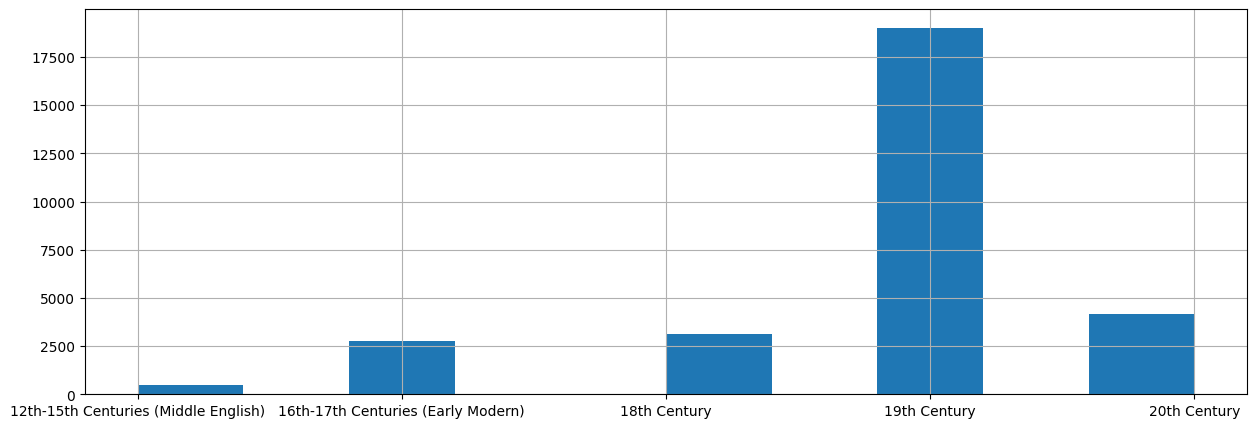

In [7]:
# vis counts by period
poetry_df['period'].sort_values().hist(figsize=(15, 5));

## **Sample text dataset**

Though we wish we could analyze all the poems in this data, Colab tends to crash if we try to use more than 4-5,000 poems —  even with DistilBert, the smaller version of BERT. This is an important limitation to keep in mind. If you'd like to use more text data, you might consider upgrading to a paid version of Colab (with more memory or GPUs) or using a compute cluster.

To reduce the number of poems, we will take a random sample of 1,000 poems from four different time periods: the 20th Century, 19th Century, 18th Century, and the Early Modern period.

In [8]:
# Filter the DataFrame for only a given time period, then randomly sample 1000 rows
nineteenth_sample = poetry_df[poetry_df['period'] == '19th Century'].sample(1000)
twentieth_sample = poetry_df[poetry_df['period'] == '20th Century'].sample(1000)
eighteenth_sample = poetry_df[poetry_df['period'] == '18th Century'].sample(1000)
sixteenth_sample = poetry_df[poetry_df['period'] == '16th-17th Centuries (Early Modern)'].sample(1000)

In [9]:
# Merge these random samples into a new DataFrame
poetry_df = pd.concat([sixteenth_sample, eighteenth_sample, twentieth_sample, nineteenth_sample])

In [10]:
poetry_df['period'].value_counts()

,count
period,
16th-17th Centuries (Early Modern),1000
18th Century,1000
20th Century,1000
19th Century,1000


Finally, let's make a list of poems from our Pandas DataFrame.

In [11]:
poetry_texts = poetry_df['text'].tolist()

Let's examine a poem in our dataset:

In [12]:
len(poetry_texts)

4000

In [13]:
print(poetry_texts[2])

When I consider how my light is spent
Ere half my days in this dark world and wide,
And that one talent which is death to hide
Lodg'd with me useless, though my soul more bent
To serve therewith my Maker, and present
My true account, lest he returning chide,
"Doth God exact day-labour, light denied?"
I fondly ask. But Patience, to prevent
That murmur, soon replies: "God doth not need
Either man's work or his own gifts: who best
Bear his mild yoke, they serve him best. His state
Is kingly; thousands at his bidding speed
And post o'er land and ocean without rest:
They also serve who only stand and wait." 


## **Encode/tokenize text data for BERT**

Next we need to transform our poems into a format that BERT (via Huggingface) will understand. This is called *tokenizing* the data.

We will tokenize the poems with the `tokenizer()` from HuggingFace's `DistilBertTokenizerFast`. Here's what the `tokenizer()` will do:

1. Truncate the texts if they're more than 512 tokens or pad them if they're fewer than 512 tokens. If a word is not in BERT's vocabulary, it will be broken up into smaller "word pieces," demarcated by a `##`.

2. Add in special tokens to help BERT:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence
    - [PAD] — Padding at the end of the document as many times as necessary, up to 512 tokens
    - &#35;&#35; — Start of a "word piece"

Here we will load `DistilBertTokenizerFast` from `transformers` library, which will help us transform and encode the texts so they can be used with BERT.

In [14]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [15]:
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

Let's examine the first tokenized poem. We can see that the special BERT tokens have been inserted where necessary.

In [16]:
' '.join(tokenized_poems[2].tokens)

'[CLS] when i consider how my light is spent er ##e half my days in this dark world and wide , and that one talent which is death to hide lo ##d ##g \' d with me useless , though my soul more bent to serve there ##with my maker , and present my true account , lest he returning chi ##de , " dot ##h god exact day - labour , light denied ? " i fond ##ly ask . but patience , to prevent that murmur , soon replies : " god dot ##h not need either man \' s work or his own gifts : who best bear his mild yo ##ke , they serve him best . his state is king ##ly ; thousands at his bidding speed and post o \' er land and ocean without rest : they also serve who only stand and wait . " [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

## **Load pre-trained BERT model**

Here we will load a pre-trained BERT model. To speed things up we will use a GPU, but using GPU involves a few extra steps.
The command `.to("cuda")` moves data from regular memory to the GPU's memory.




In [17]:
#device = 'mps' # apple silicon gpu
device = 'cuda' # nvidia gpu
#device = 'cpu' # slooooow

In [18]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [19]:
# check device in use
model.device

device(type='cuda', index=0)

## **Get BERT word embeddings for each document in a collection**

For each poem in our list `poetry_texts`, we will tokenize the poem, and we will extract the vocabulary word ID for each word/token in the poem (to use for later reference). Then we will run the tokenized poem through the BERT model and extract the contextual vectors for each word/token in the poem.

We thus create two big lists for all the poems in our collection — `doc_word_ids` and `doc_word_vectors`.

In [20]:
%%time
# List of vocabulary word IDs for all the words in each document (aka each poem)
doc_word_ids = []
# List of word vectors for all the words in each document (aka each poem)
doc_word_vectors = []

# slice each poem to ignore the first (0th) and last (-1) special BERT tokens
# generally do not want to do this, but here we only want the regular embeddings
start_of_words = 1
end_of_words = -1

# Below we will index the 0th or first document, which will be the only document, since we're analzying one poem at a time
first_document = 0

for i, poem in enumerate(poetry_texts):

    # Here we tokenize each poem with the DistilBERT Tokenizer
    inputs = tokenizer(poem, return_tensors="pt", truncation=True, padding=True)

    # Here we extract the vocabulary word ids for all the words in the poem (the first or 0th document, since we only have one document)
    # We ignore the first and last special BERT tokens
    # We also convert from a Pytorch tensor to a numpy array
    doc_word_ids.append(inputs.input_ids[first_document].numpy()[start_of_words:end_of_words])

    # Here we send the tokenized poems to the GPU
    # The model is already on the GPU, but this poem isn't, so we send it to the GPU
    inputs.to(device)
    # Here we run the tokenized poem through the DistilBERT model
    outputs = model(**inputs)

    # We take every element from the first or 0th document, from the 2nd to the 2nd-to-last position
    # Grabbing the last layer is one way of getting token vectors. There are different ways to get vectors with different pros and cons
    doc_word_vectors.append(outputs.last_hidden_state[first_document,start_of_words:end_of_words,:].detach().cpu().numpy())


CPU times: user 45.6 s, sys: 1.76 s, total: 47.4 s
Wall time: 48.3 s


Confirm that we have the same number of documents for both the tokens and the vectors:

In [21]:
len(doc_word_ids), len(doc_word_vectors)

(4000, 4000)

In [22]:
doc_word_ids[2], doc_word_vectors[2]

(array([ 2043,  1045,  5136,  2129,  2026,  2422,  2003,  2985,  9413,
         2063,  2431,  2026,  2420,  1999,  2023,  2601,  2088,  1998,
         2898,  1010,  1998,  2008,  2028,  5848,  2029,  2003,  2331,
         2000,  5342,  8840,  2094,  2290,  1005,  1040,  2007,  2033,
        11809,  1010,  2295,  2026,  3969,  2062,  6260,  2000,  3710,
         2045, 24415,  2026,  9338,  1010,  1998,  2556,  2026,  2995,
         4070,  1010, 26693,  2002,  4192,  9610,  3207,  1010,  1000,
        11089,  2232,  2643,  6635,  2154,  1011,  4428,  1010,  2422,
         6380,  1029,  1000,  1045, 13545,  2135,  3198,  1012,  2021,
        11752,  1010,  2000,  4652,  2008, 20227,  1010,  2574, 14054,
         1024,  1000,  2643, 11089,  2232,  2025,  2342,  2593,  2158,
         1005,  1055,  2147,  2030,  2010,  2219,  9604,  1024,  2040,
         2190,  4562,  2010, 10256, 10930,  3489,  1010,  2027,  3710,
         2032,  2190,  1012,  2010,  2110,  2003,  2332,  2135,  1025,
      

## **Concatenate all word IDs/vectors for all documents**

Each element of these lists contains all the tokens/vectors for one document. But we want to concatenate them into two giant collections.

In [23]:
all_word_ids = np.concatenate(doc_word_ids)
all_word_vectors = np.concatenate(doc_word_vectors, axis=0)

We want to make comparisons between vectors quickly. We'll use cosine similarity, or the dot product of `l2`-normed vectors. So we need to norm our embeddings.

In [24]:
# normalize embeddings
row_norms = np.sqrt(np.sum(all_word_vectors ** 2, axis=1))
all_word_vectors /= row_norms[:,np.newaxis]

## **Find all word positions in a collection**

We can use the array `all_word_ids` to find all the places, or *positions*, in the collection where a word appears.

We can find a word's vocab ID in BERT with `tokenizer.vocab` and then check to see where/how many times this ID occurs in `all_word_ids`.

In [25]:
def get_word_positions(words):
    """This function accepts a list of words, rather than a single word"""

    # Get word/vocabulary ID from BERT for each word
    word_ids = [tokenizer.vocab[word] for word in words]

    # Find all the positions where the words occur in the collection
    word_positions = np.where(np.isin(all_word_ids, word_ids))[0]

    return word_positions

Here we'll check to see all the places where the word "bank" appears in the collection.

In [26]:
get_word_positions(["bank"])

array([ 27480,  42554,  67397, 119661, 143068, 152965, 191026, 191890,
       192027, 194480, 195296, 207876, 210179, 215969, 228993, 230131,
       245924, 246328, 256634, 329982, 335890, 335892, 341349, 396591,
       430701, 452241, 452531, 455398, 455587, 463131, 521234, 589208,
       599572, 612858, 616905, 621894, 627090, 652032, 667161, 685211,
       685972, 687244, 712174, 731705, 747495, 753595, 754759, 769824,
       779032, 781639, 794975, 805323, 869070, 881499, 881507, 912877,
       930161, 932727, 934337])

In [27]:
word_positions = get_word_positions(["bank"])

## **Find word from word position**

Nice! Now we know all the positions where the word "bank" appears in the collection. But it would be more helpful to know the actual words that appear in context around it. To find these context words, we have to convert position IDs back into words.

In [28]:
# Here we create an array so that we can go backwards from numeric token IDs to words
word_lookup = np.empty(tokenizer.vocab_size, dtype="O")

for word, index in tokenizer.vocab.items():
    word_lookup[index] = word

Now we can use `word_lookup` to find a word based on its position in the collection.

In [29]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:
    print(f'{word_position:>10} {word_lookup[all_word_ids[word_position]]}')

     27480 bank
     42554 bank
     67397 bank
    119661 bank
    143068 bank
    152965 bank
    191026 bank
    191890 bank
    192027 bank
    194480 bank
    195296 bank
    207876 bank
    210179 bank
    215969 bank
    228993 bank
    230131 bank
    245924 bank
    246328 bank
    256634 bank
    329982 bank
    335890 bank
    335892 bank
    341349 bank
    396591 bank
    430701 bank
    452241 bank
    452531 bank
    455398 bank
    455587 bank
    463131 bank
    521234 bank
    589208 bank
    599572 bank
    612858 bank
    616905 bank
    621894 bank
    627090 bank
    652032 bank
    667161 bank
    685211 bank
    685972 bank
    687244 bank
    712174 bank
    731705 bank
    747495 bank
    753595 bank
    754759 bank
    769824 bank
    779032 bank
    781639 bank
    794975 bank
    805323 bank
    869070 bank
    881499 bank
    881507 bank
    912877 bank
    930161 bank
    932727 bank
    934337 bank


We can also look for the 3 words that come before "bank" and the 3 words that come after it.

In [30]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:

    # Slice 3 words before "bank"
    start_pos = word_position - 3
    # Slice 3 words after "bank"
    end_pos = word_position + 4

    context_words = word_lookup[all_word_ids[start_pos:end_pos]]
    # Join the words together
    context_words = ' '.join(context_words)
    print(word_position, context_words)

27480 pride above thy bank ##es . "
42554 ##tty * * bank , the which
67397 here by this bank of lil ##ies
119661 sent , the bank ##es to weep
143068 vp ##pon a bank with roses set
152965 ? on sandy bank of late ,
191026 down upon a bank , where love
191890 on a summer bank , to sing
192027 bends on the bank , amid the
194480 er yo ##n bank and o '
195296 " see this bank - note -
207876 hedge , and bank , and stil
210179 river ' s bank , in fable
215969 ##ied a western bank ' s still
228993 bee , from bank to bow ##er
230131 cows ##lip - bank and shady willow
245924 , on some bank beside a river
246328 pri ##m ##rose bank , her throne
256634 on the green bank of clear al
329982 leaving on the bank his spear against
335890 , shooting from bank to bank ,
335892 from bank to bank , now in
341349 residence at allan bank . the long
396591 sees but the bank that from thee
430701 bright gem every bank and trembling leaf
452241 shrine is a bank of so ##d
452531 shrine is a bank of so ##d
455398

Let's make some functions that will help us get the context words around a certain word position for whatever size window (certain number of words before and after) that we want.

The first function `get_context()` will simply return the tokens without cleaning them, and the second function `get_context_clean()` will return the tokens in a more readable fashion.

In [31]:
def get_context(word_id, window_size=10):

    """Simply get the tokens that occur before and after word position"""

    start_pos = max(0, word_id - window_size) # The token where we will start the context view
    end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

    # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
    tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]

    context_words = " ".join(tokens)

    return context_words

In [32]:
import re

def get_context_clean(word_id, window_size=10):

    """Get the tokens that occur before and after word position AND make them more readable"""

    keyword = word_lookup[all_word_ids[word_id]]
    start_pos = max(0, word_id - window_size) # The token where we will start the context view
    end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

    # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
    tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]

    # Make wordpieces slightly more readable
    # This is probably not the most efficient way to clean and correct for weird spacing
    context_words = " ".join(tokens)
    context_words = re.sub(r'\s+([##])', r'\1', context_words)
    context_words = re.sub(r'##', r'', context_words)
    context_words = re.sub('\s+\'s', '\'s', context_words)
    context_words = re.sub('\s+\'d', '\'d', context_words)
    context_words = re.sub('\s\'er', '\'er', context_words)
    context_words = re.sub(r'\s+([-,:?.!;])', r'\1', context_words)
    context_words = re.sub(r'([-\'"])\s+', r'\1', context_words)
    context_words = re.sub('\s+\'s', '\'s', context_words)
    context_words = re.sub('\s+\'d', '\'d', context_words)

    # Bold the keyword by putting asterisks around it
    if keyword in context_words:
        context_words = re.sub(f"\\b{keyword}\\b", f"**{keyword}**", context_words)
        context_words = re.sub(f"\\b({keyword}[esdtrlying]+)\\b", fr"**\1**", context_words)

    return context_words

To visualize the search keyword even more easily, we're going to import a couple of Python modules that will allow us to output text with bolded words and other styling. Here we will make a function `print_md()` that will allow us to print with Markdown styling.

In [33]:
from IPython.display import Markdown, display

def print_md(string):
    display(Markdown(string))

In [34]:
word_positions = get_word_positions(["bank"])
for word_position in word_positions:
    print_md(f"{word_position}:  {get_context_clean(word_position)}")

27480:  up, rise, and swell with pride above thy **bankes**. "now is not every tide. tame

42554:  silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay

67397:  illis, rest but a while here by this **bank** of lilies; and lend a gentle ear to

119661:  threw, such sounds yet forth it sent, the **bankes** to weepe that drue, as down

143068:  hath so plagued mee. vppon a **bank** with roses set about, where pretty turtles ioyn

152965:  , to see me as you see? on sandy **bank** of late, i saw this woman sit; where

191026:  -see tides! i laid me down upon a **bank**, where love lay sleeping; i heard among the

191890:  green abode, and, seated on a summer **bank**, to sing no earthly music; in a spot

192027:  ; from where the pensile birch bends on the **bank**, amid the clustered group of the dark hollie

194480:  dearie. ii. o 'er yon **bank** and o 'er yon brae, o

195296:  , a senator addressing, said: "see this **bank**-note-lo! a blessing-breathe on

207876:  waves efface pathway, and hedge, and **bank**, and stile!-i find but one

210179:  [ 1 ] thus, on the river's **bank**, in fabled lore, the rustic stands;

215969:  . distant a little mile he spied a western **bank**'s still sunny side, and right toward the

228993:  and our own. thus as the bee, from **bank** to bower, assiduous sips at

230131:  , in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead

245924:  , and in our mossy valleys, on some **bank** beside a river clear, throw thy silk draperies

246328:  under her dominion placed. upon a primrose **bank**, her throne of quietness, she sits alone

256634:  , 'mid the circling wood, on the green **bank** of clear alb [ = u ] nea

329982:  course he, chief of heroes, leaving on the **bank** his spear against a tamarisk reclined,

335890:  still water, with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift

335892:  , with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift athwa

341349:  grasmere, chiefly during our residence at allan **bank**. the long poem on my own education was,

396591:  deride that shortsighted one sees but the **bank** that from thee is flying, not the one which

430701:  thou seen a vernal morning bright gem every **bank** and trembling leaf with dews, tinging the

452241:  a buttercup bright, and our shrine is a **bank** of sod, but still we share st.

452531:  a buttercup bright, and our shrine is a **bank** of sod, but still we share st.

455398:  in gage. patience, little heart. upon a **bank**, easeless with knobs of gold, beneath

455587:  hidden enemy must lurk within the clouds above that **bank**, it strained so wildly its pale, stubborn eye

463131:  , millionaires in legend-wealth, though no **bank** would back 'em, but old benny havens

521234:  ns and great birds watch and go fishing on the **bank**-side. no man dare go alone in the

589208:  gossamers of silver lace, and the turf **bank** wears with glee black and silver filigree.

599572:  dan shall have the pennies to save in his **bank**; anne shall have the keys to make a pretty

612858:  snare the bulky trout that lurked under the **bank** of yonder brook. indeed, he taught me

616905:  , and as i lay upon a scent-warm **bank**, i fell away, slipped back from earth,

621894:  her ankles gleam; she scrambles up the grassy **bank** and on, though courage and quick breath are nearly

627090:  ed turned the crank, an 'there on the **bank** they squatted like bumps on a log. for

652032:  where some sweet stream steals singing by a mossy **bank**; where violets vie in color with the summer

667161:  the gap below the plank ) from the great north **bank** to the caribbees ( down by the

685211:  eau, gay with loves, lie there beneath a **bank** of eglantine, that heaps a

685972:  shouts greeting from his easy chair; high on a **bank** our leader stands, reviews and ranks his motley

687244:  rrow. when he gaed up the tennies **bank**, as he gaed mony a morrow,

712174:  . it was a stream of living beams, whose **bank** on either side by the cloud's cleft

731705:  i take your money, i put it in your **bank**, and live sumptuously on the interest.

747495:  said was true: i wrecked my father's **bank** with my loans to dabble in wheat; but

753595:  his shroud? "i, "said the **bank**, "tho 'he played me a prank,

754759:  back in the brimstone from above-is **banked** of violet, rose, and fern: '

769824:  's daughter, and later became president of the **bank**-always looking forward to some leisure to write an

779032:  .-scene, a wood ending in a steep **bank** over a dry dene, winefred having

781639:  . and one, a green thyme-honoured **bank**, where flowers are growing wild and rank, like

794975:  vernal season still? here it decks the **bank** alone, where the milkmaid throws a stone at

805323:  and watch the goatherd down that high-**bank**'d path urging his flock grotesque; and bidding

869070:  crystal spray a moor-hen darted out from the **bank** thereabout, and through the stream-shine

881499:  fast, sit fast by me, sweetheart! the **bank** is steep to ride! 'the **bank** is steep

881507:  ! the **bank** is steep to ride! 'the **bank** is steep for a strong man's leap,

912877:  and the drooping willows that wave on the **bank**. i see the abbey, both turret and tower

930161:  wreathed urn? beneath what mossy **bank** enshrined, within what ivy-mantle

932727:  descried, like a stealthy cloud-**bank** making up to windward with the tide, those

934337:  * * * * i stole along the flowery **bank**, while many a bending seagrape [ 1

Here we make a list of all the context views for our keyword.

In [35]:
word_positions = get_word_positions(["bank"])

keyword_contexts = []
keyword_contexts_tokens = []

for position in word_positions:
    keyword_contexts.append(get_context_clean(position))
    keyword_contexts_tokens.append(get_context(position))

## **Get word vectors and reduce them with PCA**

Finally, we don't just want to *read* all the instances of "bank" in the collection, we want to *measure* the similarity of all the instances of "bank."

To measure similarity between all the instances of "bank," we will take the vectors for each instance and then use PCA to reduce each 768-dimensionsal vector to the 2 dimensions that capture the most variation.

In [36]:
word_positions = get_word_positions(["bank"])
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

PCA(n_components=2)

Then, for convenience, we will put these PCA results into a Pandas DataFrame, which will use to generate an interactive plot.

In [37]:
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens})
df.head()

,x,y,context,tokens
0,0.124478,-0.034011,"up, rise, and swell with pride above thy **bankes**. ""now is not every tide. tame","up , rise , and swell with pride above thy bank ##es . "" now is not every tide . tame"
1,0.132484,0.013037,"silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay","silver streaming them ##mes ; whose ru ##tty * * bank , the which his river hem ##mes , was pay"
2,0.132928,0.015664,"illis, rest but a while here by this **bank** of lilies; and lend a gentle ear to","##ill ##is , rest but a while here by this bank of lil ##ies ; and lend a gentle ear to"
3,0.117657,0.006704,"threw, such sounds yet forth it sent, the **bankes** to weepe that drue, as down","threw , such sounds yet forth it sent , the bank ##es to weep ##e that dr ##ue , as down"
4,0.137287,0.071366,"hath so plagued mee. vppon a **bank** with roses set about, where pretty turtles ioyn","hat ##h so plagued me ##e . vp ##pon a bank with roses set about , where pretty turtles io ##yn"


## **Match context with original text and metadata**

It's helpful (and fun!) to know where each instance of a word actually comes from — which poem, which poet, which time period, which Public-Domain-Poetry.com web page. The easiest method we've found for matching a bit of context with its original poem and metdata is to 1) add a tokenized version of each poem to our original Pandas Dataframe 2) check to see if the context shows up in a poem 3) and if so, grab the original poem and metadata.

In [38]:
# Tokenize all the poems
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

# Get a list of all the tokens for each poem
all_tokenized_poems = []
for i in range(len(tokenized_poems['input_ids'])):
    all_tokenized_poems.append(' '.join(tokenized_poems[i].tokens))

# Add them to the original DataFrame
poetry_df['tokens'] = all_tokenized_poems

In [39]:
poetry_df.head(2)

,author,title,text,lifespan,birth_year,death_year,link,period,tokens
20388,Robert Herrick,Money Makes The Mirth,"When all birds else do of their music fail,\r\nMoney's the still-sweet-singing nightingale!","Baptized - August 24, 1591- October 1674",1591.0,1674.0,http://public-domain-poetry.com/robert-herrick/money-makes-the-mirth-2240,16th-17th Centuries (Early Modern),"[CLS] when all birds else do of their music fail , money ' s the still - sweet - singing nightingale ! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA..."
21597,Robert Herrick,On Himself,"Let me not live if I not love:\r\nSince I as yet did never prove\r\nWhere pleasures met, at last do find\r\nAll pleasures meet in womankind.","Baptized - August 24, 1591- October 1674",1591.0,1674.0,http://public-domain-poetry.com/robert-herrick/on-himself-19293,16th-17th Centuries (Early Modern),"[CLS] let me not live if i not love : since i as yet did never prove where pleasures met , at last do find all pleasures meet in woman ##kind . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD..."


In [40]:
def find_original_poem(rows):

    """This function checks to see whether the context tokens show up in the original poem,
    and if so, returns metadata about the title, author, period, and URL for that poem"""

    text = rows['tokens'].replace('**', '')
    text = text[55:70]

    if poetry_df['tokens'].str.contains(text, regex=False).any() == True :
        row = poetry_df[poetry_df['tokens'].str.contains(text, regex=False)].values[0]
        title, author, period, link = row[0], row[1], row[7], row[6]
        return author, title, period, link
    else:
        return None, None, None, None

In [41]:
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

In [42]:
df.head()

,x,y,context,tokens,title,author,period,link
0,0.124478,-0.034011,"up, rise, and swell with pride above thy **bankes**. ""now is not every tide. tame","up , rise , and swell with pride above thy bank ##es . "" now is not every tide . tame",The Speeches Of Gratulations,Ben Jonson,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/ben-jonson/speeches-of-gratulations-2539
1,0.132484,0.013037,"silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay","silver streaming them ##mes ; whose ru ##tty * * bank , the which his river hem ##mes , was pay","Prothalamion: Or, A Spousall Verse",Edmund Spenser,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/edmund-spenser/prothalamion-or-a-spousall-verse-32239
2,0.132928,0.015664,"illis, rest but a while here by this **bank** of lilies; and lend a gentle ear to","##ill ##is , rest but a while here by this bank of lil ##ies ; and lend a gentle ear to",A Pastoral Upon The Birth Of Prince Charles: Presented To The King,Robert Herrick,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/robert-herrick/pastoral-upon-the-birth-of-prince-charles-presented-to-the-king-2160
3,0.117657,0.006704,"threw, such sounds yet forth it sent, the **bankes** to weepe that drue, as down","threw , such sounds yet forth it sent , the bank ##es to weep ##e that dr ##ue , as down",To Himselfe And The Harpe,Michael Drayton,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/michael-drayton/to-himselfe-and-the-harpe-14544
4,0.137287,0.071366,"hath so plagued mee. vppon a **bank** with roses set about, where pretty turtles ioyn","hat ##h so plagued me ##e . vp ##pon a bank with roses set about , where pretty turtles io ##yn",From Eclogue ij,Michael Drayton,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/michael-drayton/from-eclogue-ij-14586


## **Plot word embeddings**

Lastly, we will plot the words vectors from this DataFrame with the Python data viz library [Altair](https://altair-viz.github.io/gallery/scatter_tooltips.html).

In [43]:
alt.Chart(df,title="Word Similarity: Bank").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    # If you click a point, take you to the URL link
    href="link",
    # The categories that show up in the hover tooltip
    tooltip=['title', 'context', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: Futu

alt.Chart(...)

## **Plot word embeddings from keywords (all at once!)**

We can put the code from the previous few sections into a single cell and plot the BERT word embeddings for any list of words. Let's look at the words "nature," "religion," "science," and "art."

In [44]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
    words.append(word_lookup[all_word_ids[position]])
    keyword_contexts.append(get_context_clean(position))
    keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: Futu

alt.Chart(...)

Let's examine the words "nature," "religion," "science," and "art" again but this time color the points by their time period.

In [45]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot
color_by = 'period'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
    words.append(word_lookup[all_word_ids[position]])
    keyword_contexts.append(get_context_clean(position))
    keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: Futu

alt.Chart(...)

Let's compare the words "mean," "thin," "average", and "cruel."

In [46]:
# List of keywords that you want to compare
keywords = ['mean', 'thin', 'average', 'cruel']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
    words.append(word_lookup[all_word_ids[position]])
    keyword_contexts.append(get_context_clean(position))
    keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: Futu

alt.Chart(...)

See the difference between our static embeddings and these contextual ones

In [47]:
# List of keywords that you want to compare
keywords = ['bank', 'river', 'money', 'coffee', 'kitten']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
    words.append(word_lookup[all_word_ids[position]])
    keyword_contexts.append(get_context_clean(position))
    keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/usr/local/lib/python3.10/dist-packages/altair/utils/core.py:384: Futu

alt.Chart(...)

## **Find word similarity from a specific word position**

We can also search *all* of the vectors for words similar to a query word.

In [48]:
def get_nearest(query_vector, n=20):
    cosines = all_word_vectors.dot(query_vector)
    ordering = np.flip(np.argsort(cosines))
    return ordering[:n]

To do so, we need to find the specific word position of our desired search keyword.

In [49]:
word_positions = get_word_positions(['bank'])

for word_position in word_positions:
    print_md(f"{word_position}: {get_context_clean(word_position)}")

27480: up, rise, and swell with pride above thy **bankes**. "now is not every tide. tame

42554: silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay

67397: illis, rest but a while here by this **bank** of lilies; and lend a gentle ear to

119661: threw, such sounds yet forth it sent, the **bankes** to weepe that drue, as down

143068: hath so plagued mee. vppon a **bank** with roses set about, where pretty turtles ioyn

152965: , to see me as you see? on sandy **bank** of late, i saw this woman sit; where

191026: -see tides! i laid me down upon a **bank**, where love lay sleeping; i heard among the

191890: green abode, and, seated on a summer **bank**, to sing no earthly music; in a spot

192027: ; from where the pensile birch bends on the **bank**, amid the clustered group of the dark hollie

194480: dearie. ii. o 'er yon **bank** and o 'er yon brae, o

195296: , a senator addressing, said: "see this **bank**-note-lo! a blessing-breathe on

207876: waves efface pathway, and hedge, and **bank**, and stile!-i find but one

210179: [ 1 ] thus, on the river's **bank**, in fabled lore, the rustic stands;

215969: . distant a little mile he spied a western **bank**'s still sunny side, and right toward the

228993: and our own. thus as the bee, from **bank** to bower, assiduous sips at

230131: , in this sweet book, the cowslip-**bank** and shady willow-tree; and the fresh mead

245924: , and in our mossy valleys, on some **bank** beside a river clear, throw thy silk draperies

246328: under her dominion placed. upon a primrose **bank**, her throne of quietness, she sits alone

256634: , 'mid the circling wood, on the green **bank** of clear alb [ = u ] nea

329982: course he, chief of heroes, leaving on the **bank** his spear against a tamarisk reclined,

335890: still water, with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift

335892: , with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift athwa

341349: grasmere, chiefly during our residence at allan **bank**. the long poem on my own education was,

396591: deride that shortsighted one sees but the **bank** that from thee is flying, not the one which

430701: thou seen a vernal morning bright gem every **bank** and trembling leaf with dews, tinging the

452241: a buttercup bright, and our shrine is a **bank** of sod, but still we share st.

452531: a buttercup bright, and our shrine is a **bank** of sod, but still we share st.

455398: in gage. patience, little heart. upon a **bank**, easeless with knobs of gold, beneath

455587: hidden enemy must lurk within the clouds above that **bank**, it strained so wildly its pale, stubborn eye

463131: , millionaires in legend-wealth, though no **bank** would back 'em, but old benny havens

521234: ns and great birds watch and go fishing on the **bank**-side. no man dare go alone in the

589208: gossamers of silver lace, and the turf **bank** wears with glee black and silver filigree.

599572: dan shall have the pennies to save in his **bank**; anne shall have the keys to make a pretty

612858: snare the bulky trout that lurked under the **bank** of yonder brook. indeed, he taught me

616905: , and as i lay upon a scent-warm **bank**, i fell away, slipped back from earth,

621894: her ankles gleam; she scrambles up the grassy **bank** and on, though courage and quick breath are nearly

627090: ed turned the crank, an 'there on the **bank** they squatted like bumps on a log. for

652032: where some sweet stream steals singing by a mossy **bank**; where violets vie in color with the summer

667161: the gap below the plank ) from the great north **bank** to the caribbees ( down by the

685211: eau, gay with loves, lie there beneath a **bank** of eglantine, that heaps a

685972: shouts greeting from his easy chair; high on a **bank** our leader stands, reviews and ranks his motley

687244: rrow. when he gaed up the tennies **bank**, as he gaed mony a morrow,

712174: . it was a stream of living beams, whose **bank** on either side by the cloud's cleft

731705: i take your money, i put it in your **bank**, and live sumptuously on the interest.

747495: said was true: i wrecked my father's **bank** with my loans to dabble in wheat; but

753595: his shroud? "i, "said the **bank**, "tho 'he played me a prank,

754759: back in the brimstone from above-is **banked** of violet, rose, and fern: '

769824: 's daughter, and later became president of the **bank**-always looking forward to some leisure to write an

779032: .-scene, a wood ending in a steep **bank** over a dry dene, winefred having

781639: . and one, a green thyme-honoured **bank**, where flowers are growing wild and rank, like

794975: vernal season still? here it decks the **bank** alone, where the milkmaid throws a stone at

805323: and watch the goatherd down that high-**bank**'d path urging his flock grotesque; and bidding

869070: crystal spray a moor-hen darted out from the **bank** thereabout, and through the stream-shine

881499: fast, sit fast by me, sweetheart! the **bank** is steep to ride! 'the **bank** is steep

881507: ! the **bank** is steep to ride! 'the **bank** is steep for a strong man's leap,

912877: and the drooping willows that wave on the **bank**. i see the abbey, both turret and tower

930161: wreathed urn? beneath what mossy **bank** enshrined, within what ivy-mantle

932727: descried, like a stealthy cloud-**bank** making up to windward with the tide, those

934337: * * * * i stole along the flowery **bank**, while many a bending seagrape [ 1

In [50]:
keyword_position = word_positions[-1] # pick last of the sampled instances above

In [51]:
contexts = [get_context_clean(token_id) for token_id in get_nearest(all_word_vectors[keyword_position,:])]

for context in contexts:
    print_md(context)

* * * * i stole along the flowery **bank**, while many a bending seagrape [ 1

her ankles gleam; she scrambles up the grassy **bank** and on, though courage and quick breath are nearly

, 'mid the circling wood, on the green **bank** of clear alb [ = u ] nea

wreathed urn? beneath what mossy **bank** enshrined, within what ivy-mantle

and the drooping willows that wave on the **bank**. i see the abbey, both turret and tower

, and as i lay upon a scent-warm **bank**, i fell away, slipped back from earth,

; from where the pensile birch bends on the **bank**, amid the clustered group of the dark hollie

crystal spray a moor-hen darted out from the **bank** thereabout, and through the stream-shine

silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay

vernal season still? here it decks the **bank** alone, where the milkmaid throws a stone at

under her dominion placed. upon a primrose **bank**, her throne of quietness, she sits alone

green abode, and, seated on a summer **bank**, to sing no earthly music; in a spot

! the **bank** is steep to ride! 'the **bank** is steep for a strong man's leap,

rrow. when he gaed up the tennies **bank**, as he gaed mony a morrow,

where some sweet stream steals singing by a mossy **bank**; where violets vie in color with the summer

course he, chief of heroes, leaving on the **bank** his spear against a tamarisk reclined,

, and in our mossy valleys, on some **bank** beside a river clear, throw thy silk draperies

, to see me as you see? on sandy **bank** of late, i saw this woman sit; where

eau, gay with loves, lie there beneath a **bank** of eglantine, that heaps a

. it was a stream of living beams, whose **bank** on either side by the cloud's cleft